In [30]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import random
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve,auc

target_names = [ '0 Attrition','1 Attrition ']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
def plot_roc_curve(fper, tper,roc_auc):
    plt.plot(fper,tper,lw=2,alpha=0.8,color='b',
         label='ROC Model(area=%0.3f)'% (roc_auc))
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [2]:
df1 = pd.read_csv("training.csv")
df1['label'] = df1.Attrition
df1 = df1.drop(['Attrition'],axis=1)

df2 = pd.read_csv("testing.csv")
df2['label'] = df2.Attrition
df2 = df2.drop(['Attrition'],axis=1)

df_cat = df1.select_dtypes(include = ['O'])
for i in df_cat.columns:
    df1[i] = pd.Categorical(df1[i])
    df1[i] = df1[i].cat.codes
    df2[i] = pd.Categorical(df2[i])
    df2[i] = df2[i].cat.codes
df_cat.columns

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'label'],
      dtype='object')

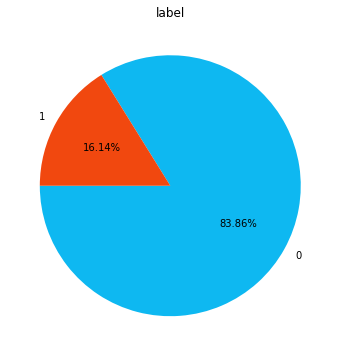

In [3]:
def target_classification(df, target):
    fig, ax = plt.subplots(figsize = (6, 6))
    
    labels = df[target].value_counts().index.tolist()
    palette = ["#0EB8F1", "#F1480F", "#971194", "#FEE715", "#101820"]

    ax.pie(df[target].value_counts(), labels = labels, autopct = '%1.2f%%', 
           startangle = 180, colors = palette[: len(labels)])

    ax.set_title(target)
    plt.show()
target_classification(df1, "label")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

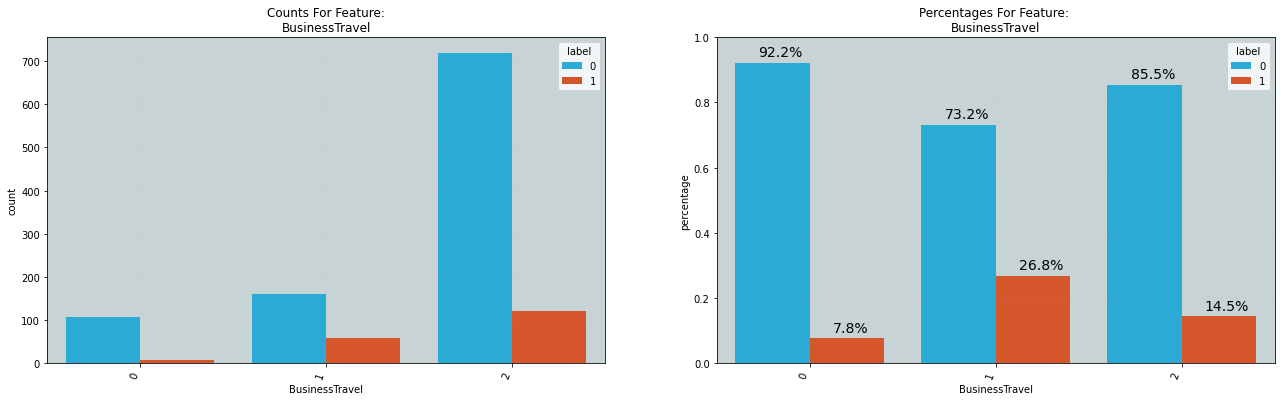

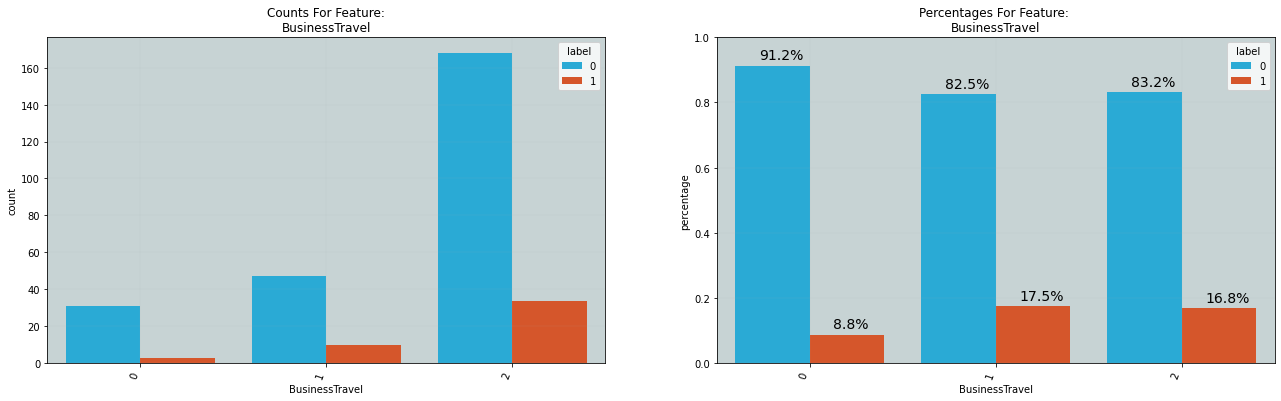

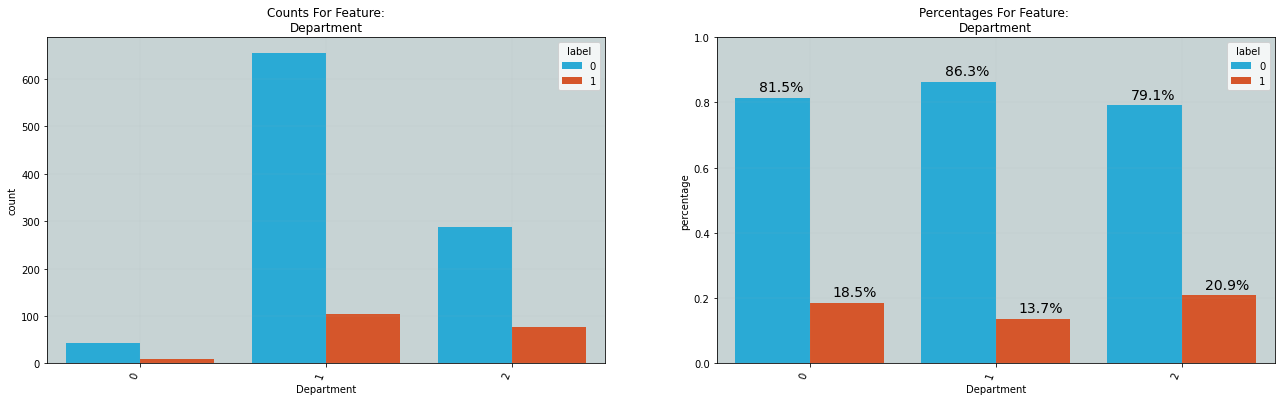

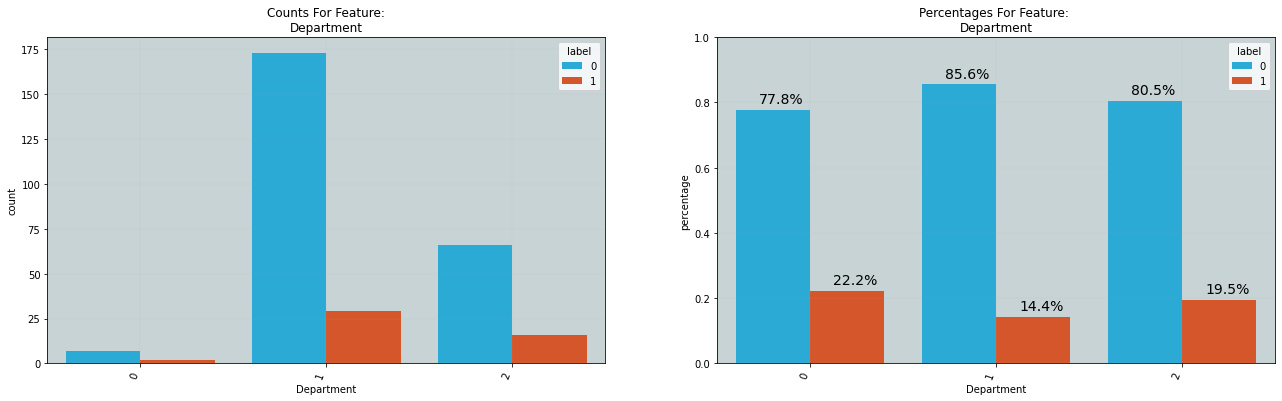

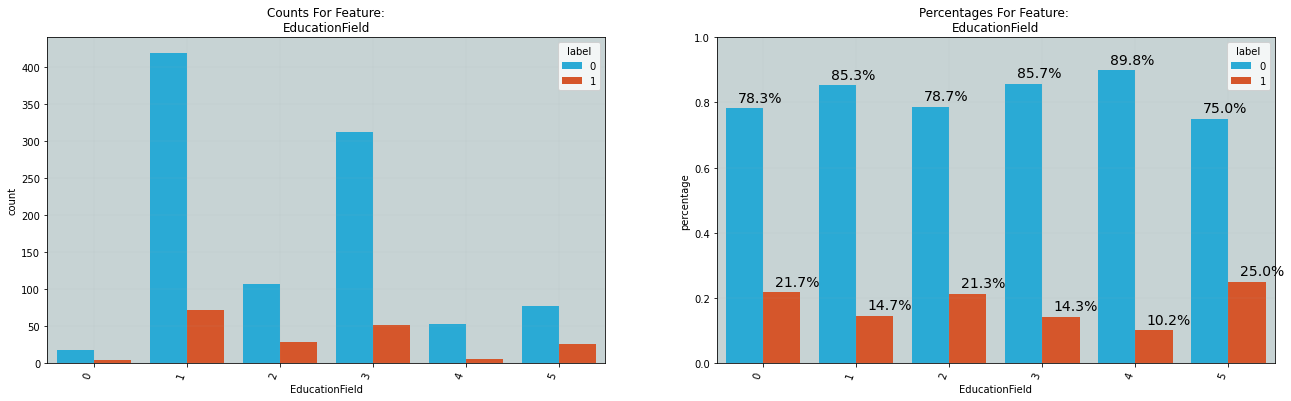

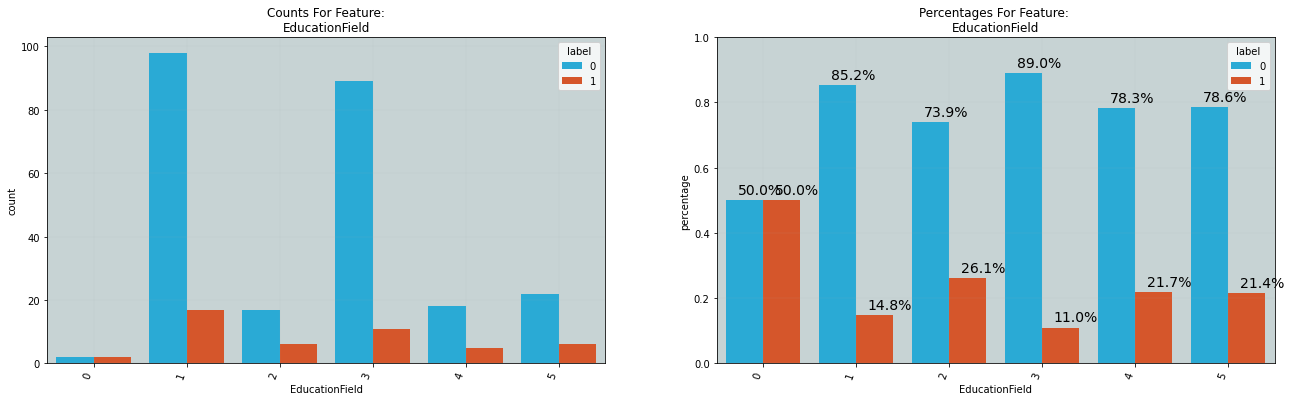

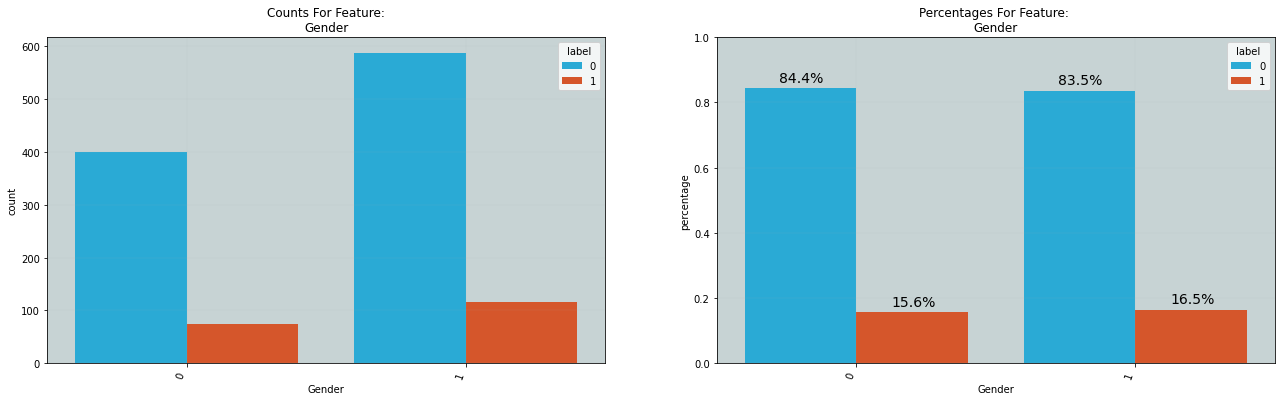

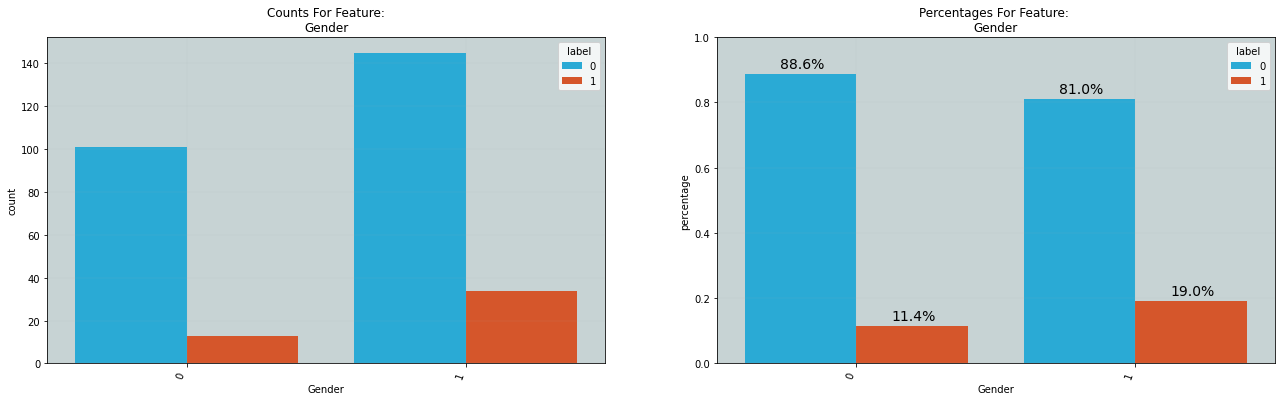

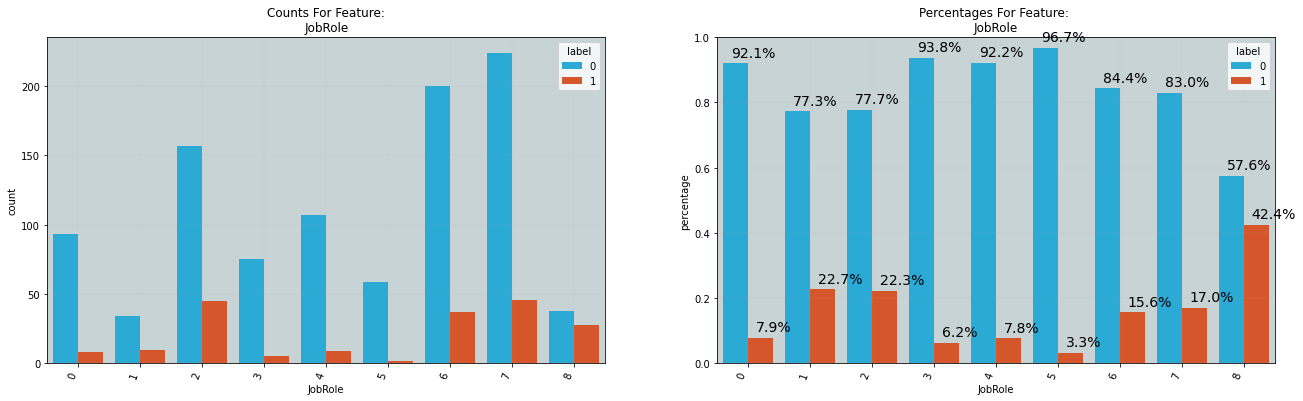

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


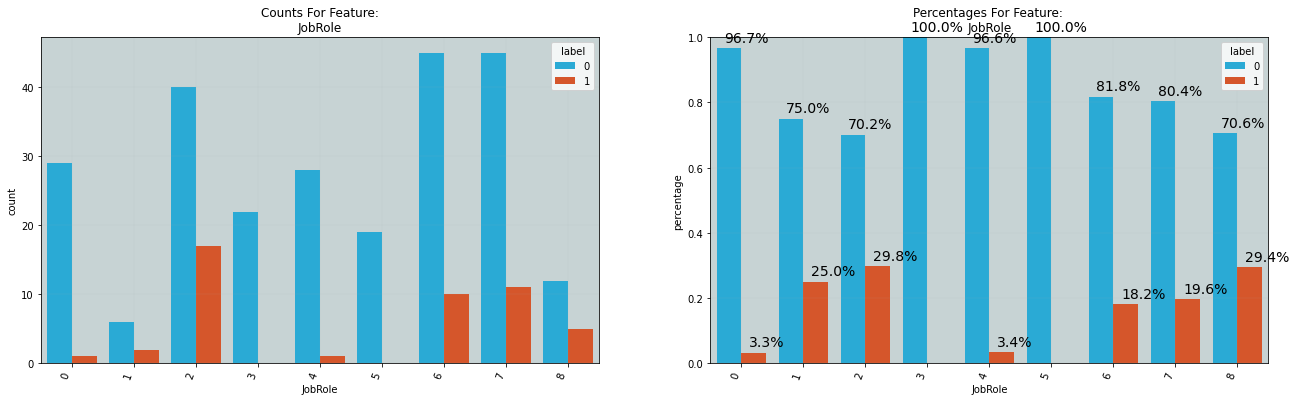

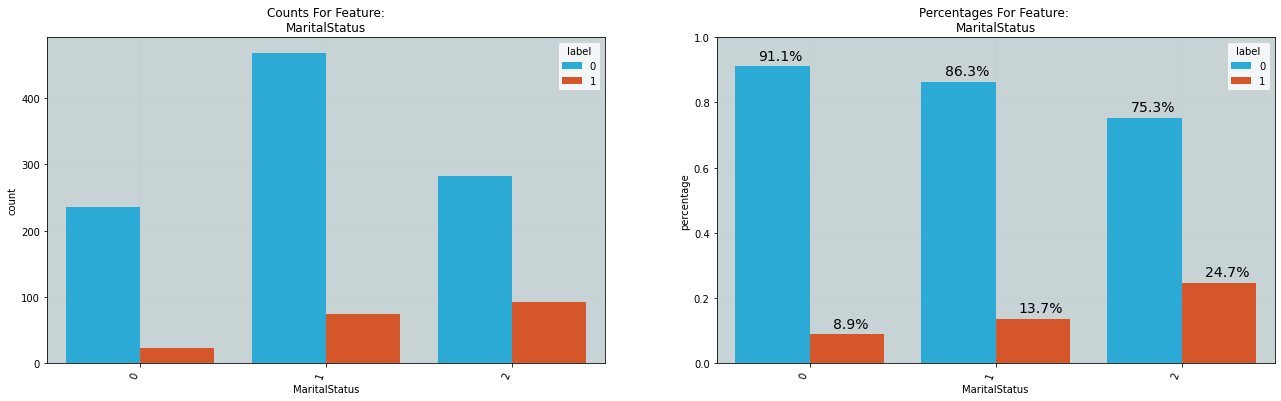

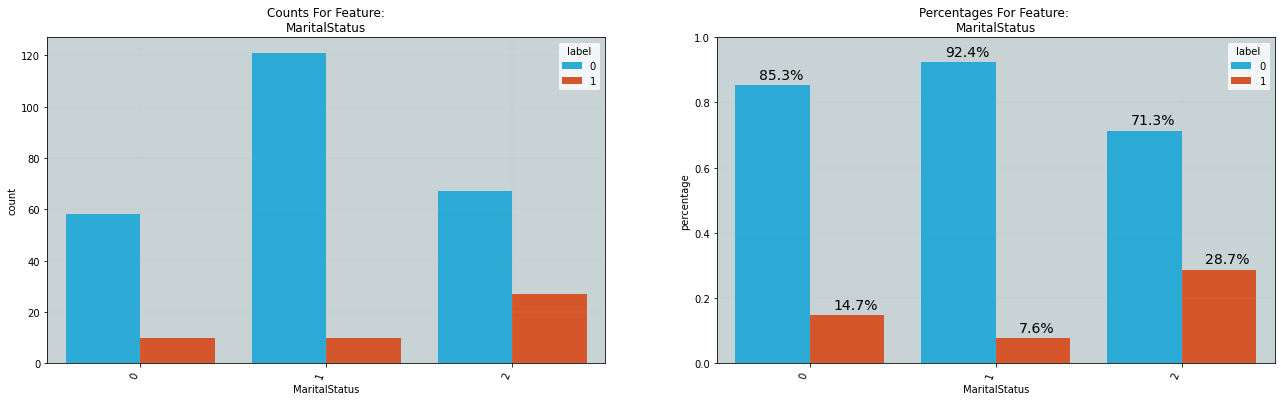

In [4]:
def count_percentage(df, col, hue):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
    order = sorted(df[col].unique())
    palette = ["#0EB8F1", "#F1480F", "#971194", "#FEE715", "#101820"]
    
    sns.countplot(col, data = df, hue = hue, ax = ax1, order = order, palette = palette[: df[hue].nunique()])
    ax1.set_title("Counts For Feature:\n" + col)

    df_temp = df.groupby(col)[hue].value_counts(normalize = True).\
    rename("percentage").\
    reset_index()
    
    fig = sns.barplot(x = col, y = "percentage", hue = hue, data = df_temp, ax = ax2, 
                      order = order, palette = palette[: df[hue].nunique()])
    fig.set_ylim(0,1)
    
    fontsize = 14 if len(order) <= 10 else 8
    for p in fig.patches:
        
        txt = "{:.1f}".format(p.get_height() * 100) + "%"
        txt_x = p.get_x() 
        txt_y = p.get_height()
        fig.text(txt_x + 0.125, txt_y + 0.02,txt, fontsize = fontsize)

    ax2.set_title("Percentages For Feature: \n" + col)
    plt.setp(ax1.get_xticklabels(), rotation=70, horizontalalignment='right')
    plt.setp(ax2.get_xticklabels(), rotation=70, horizontalalignment='right')
    
    for ax in [ax1, ax2]:
        ax.set_facecolor("#C7D3D4FF")
        ax.grid(linewidth = 0.1)
for i in df_cat.columns[:-1]:
    count_percentage(df1, i, "label")
    count_percentage(df2, i, "label")

<ipython-input-5-edb5cff284fe>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 4, figsize = (25, 5))


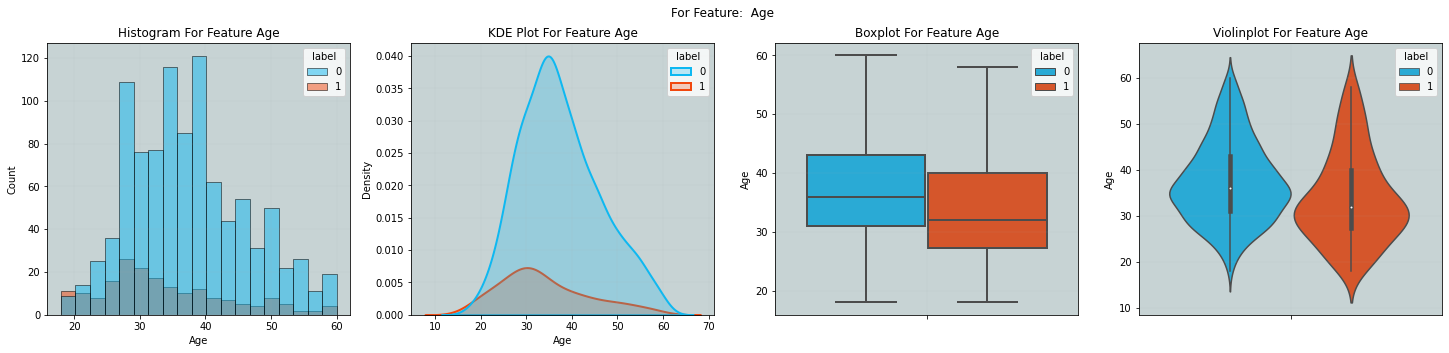

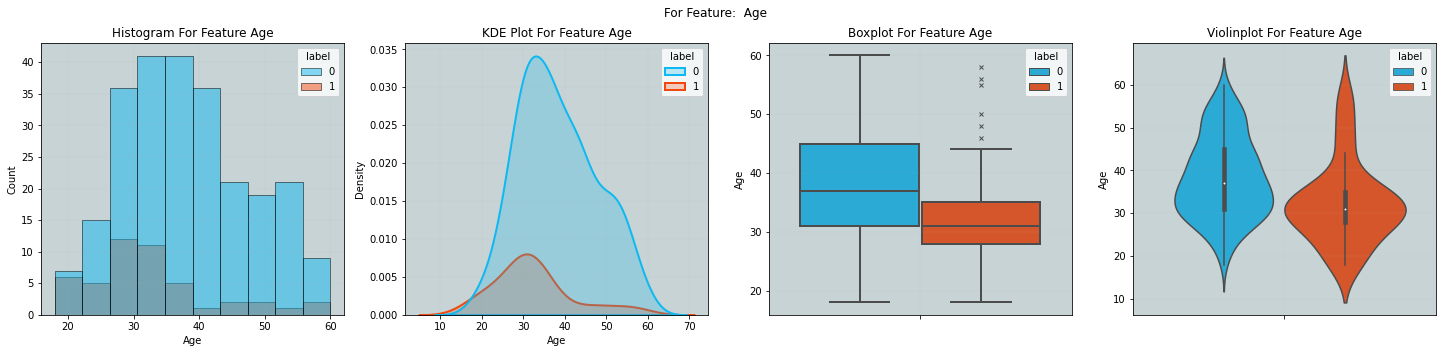

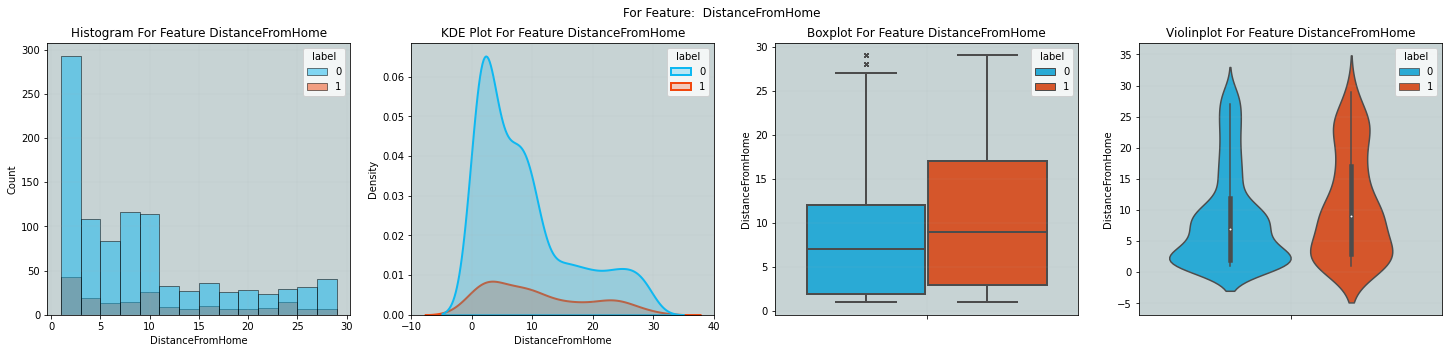

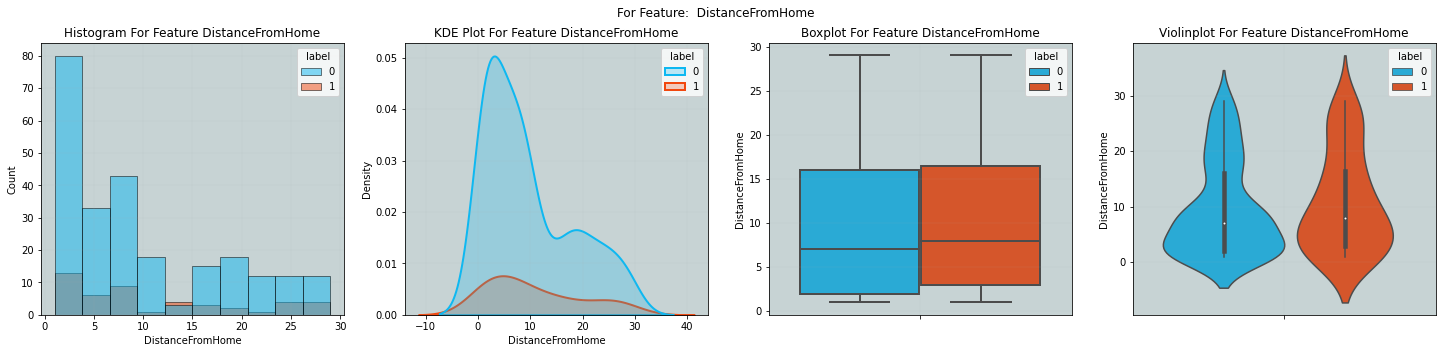

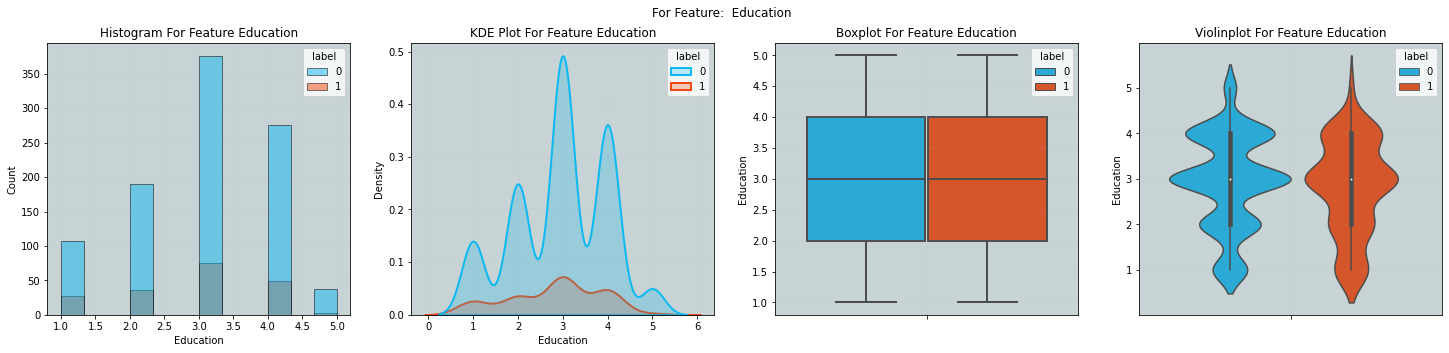

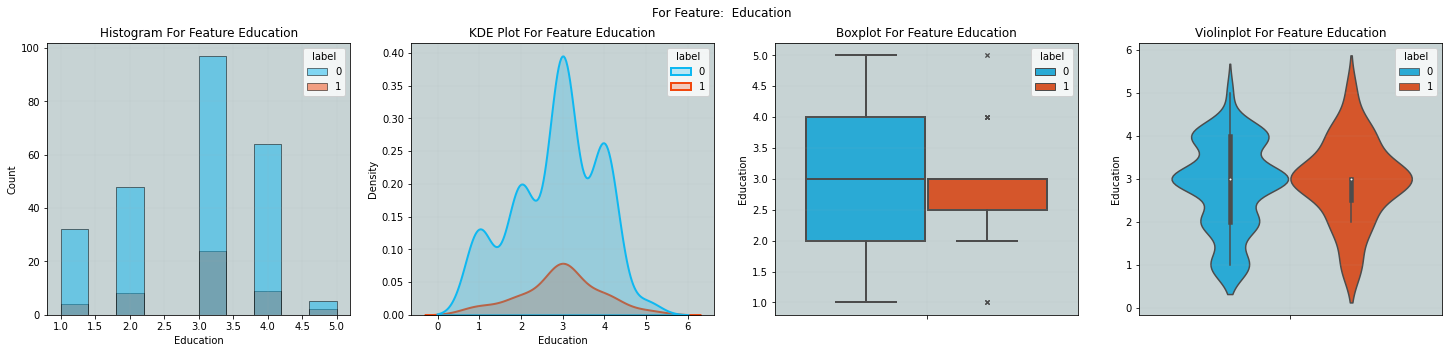

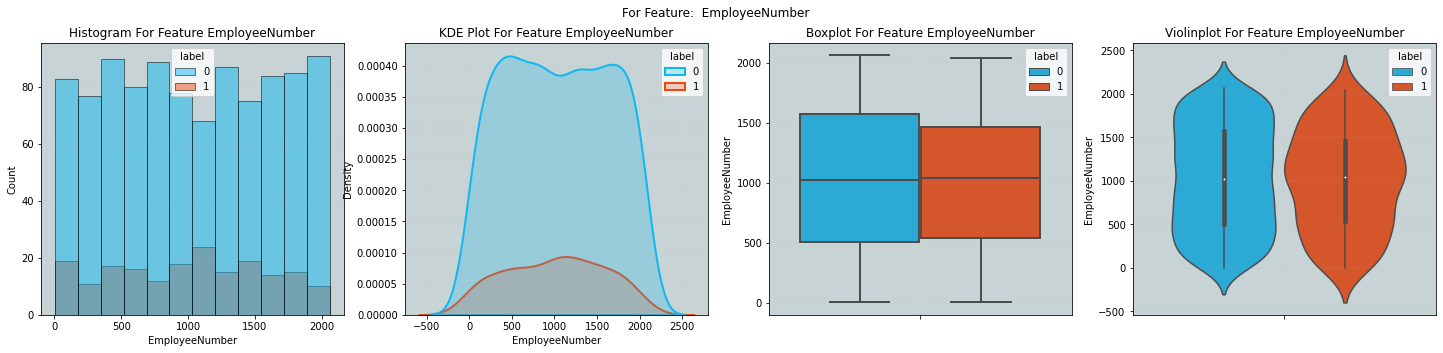

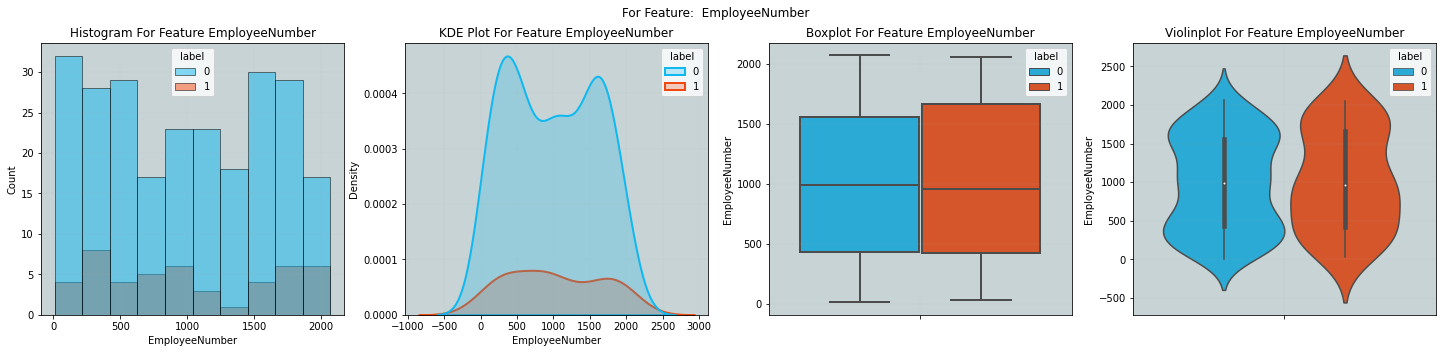

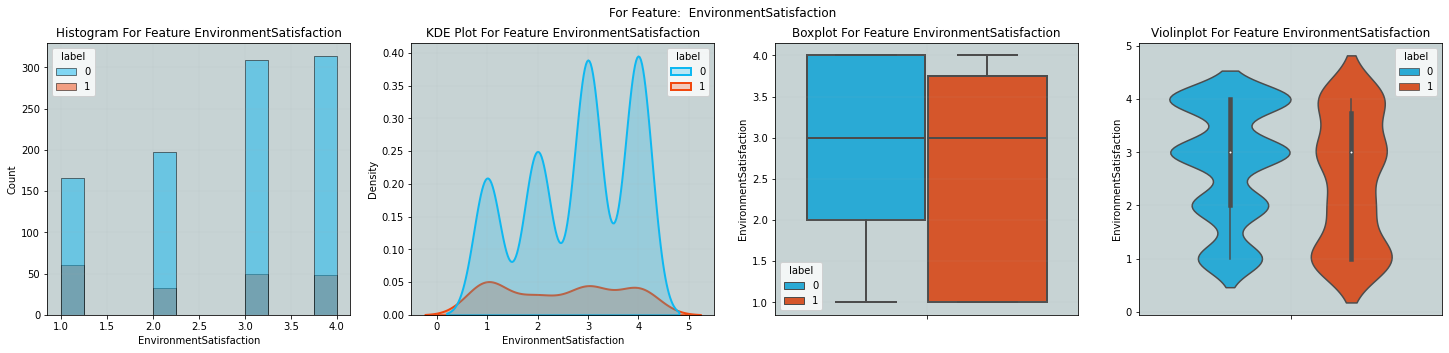

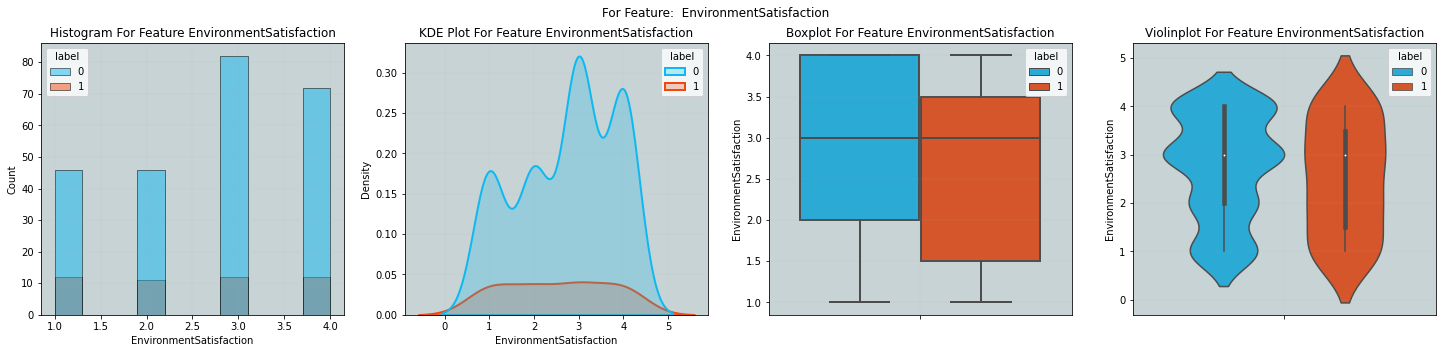

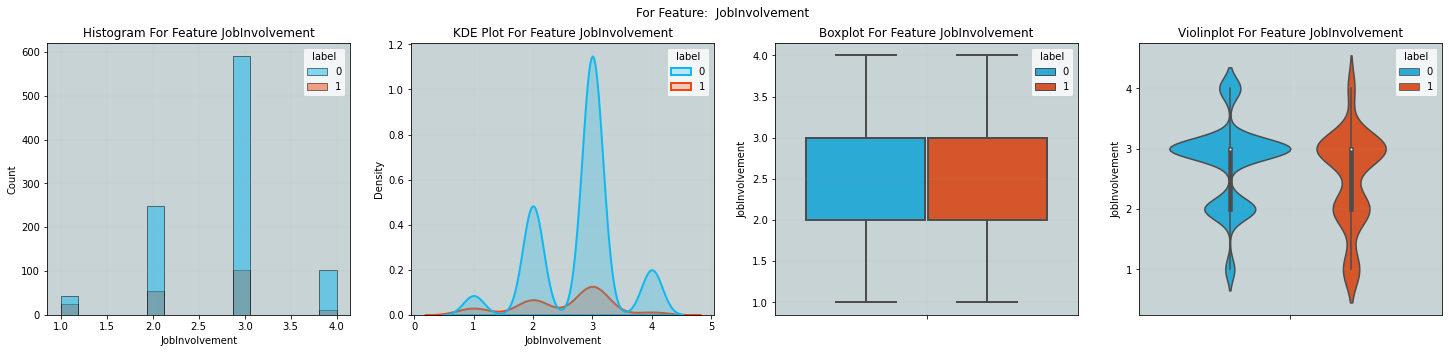

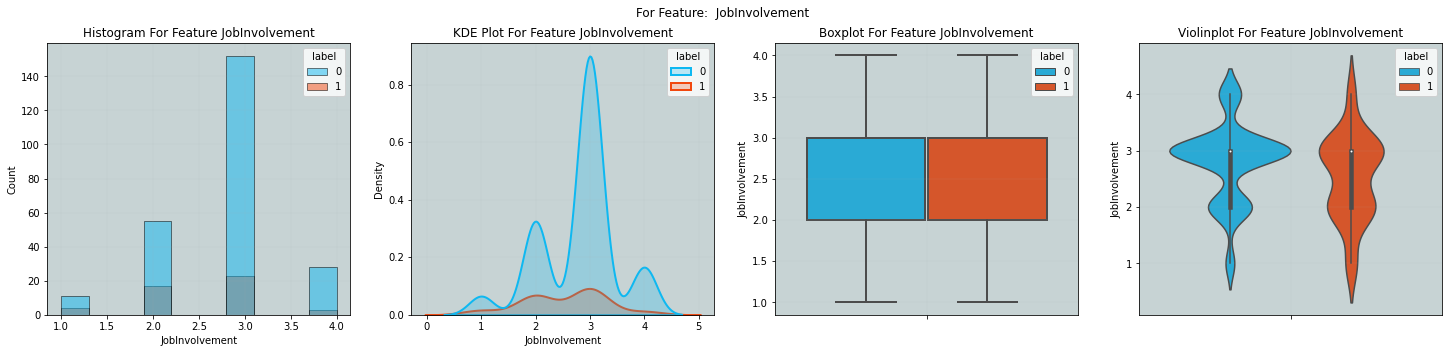

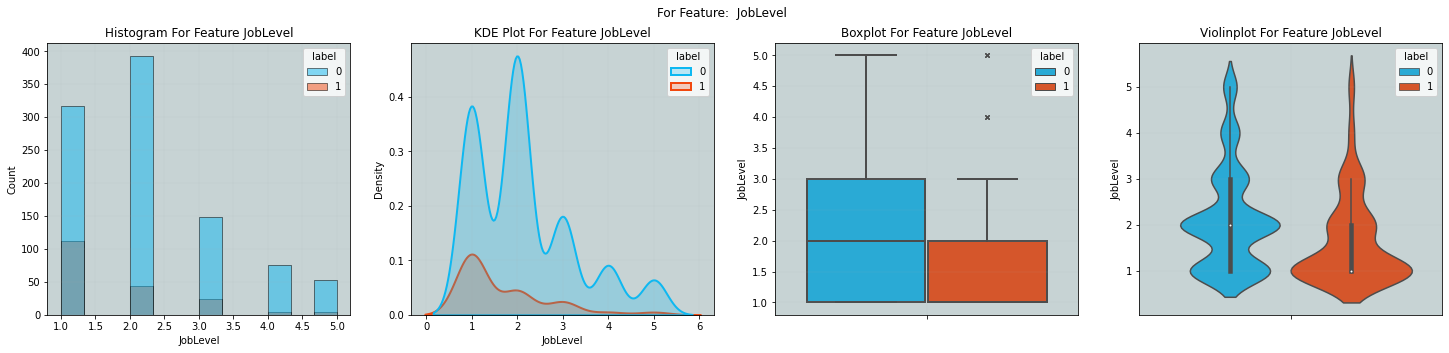

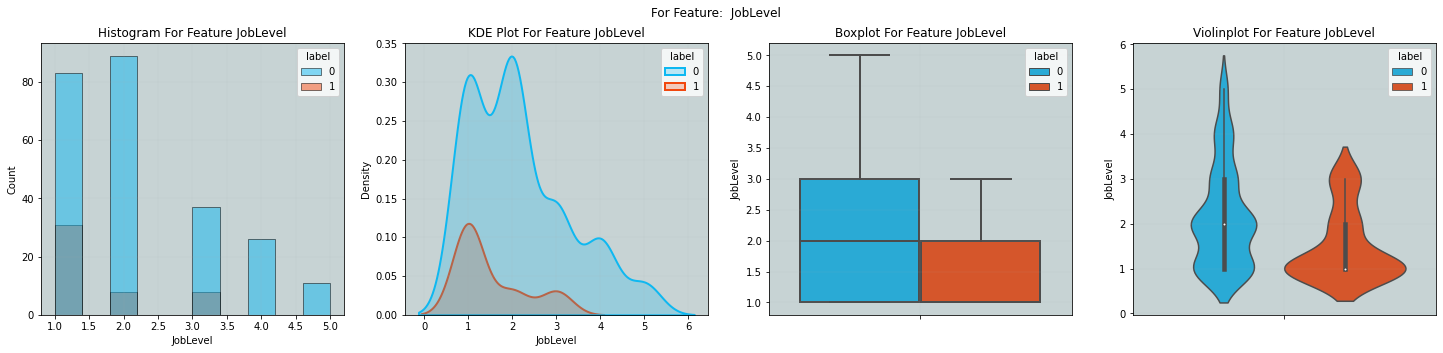

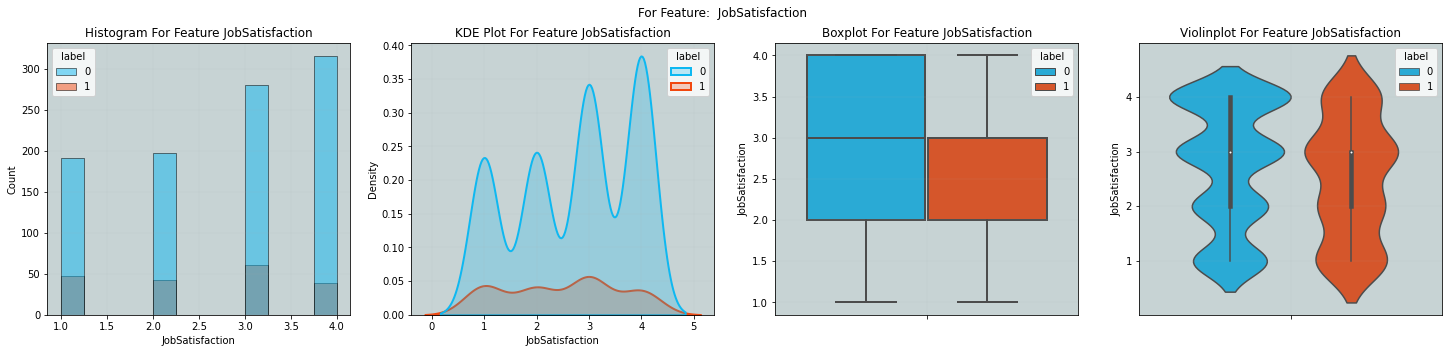

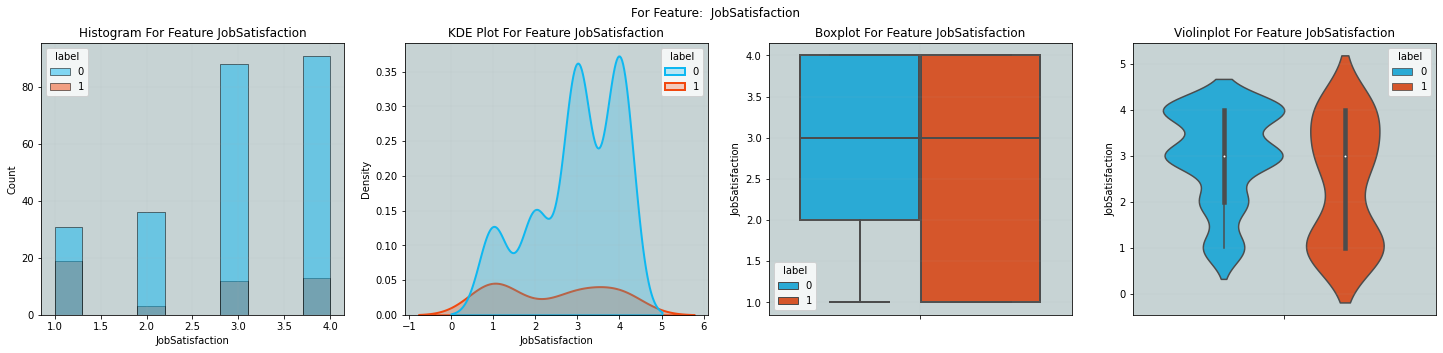

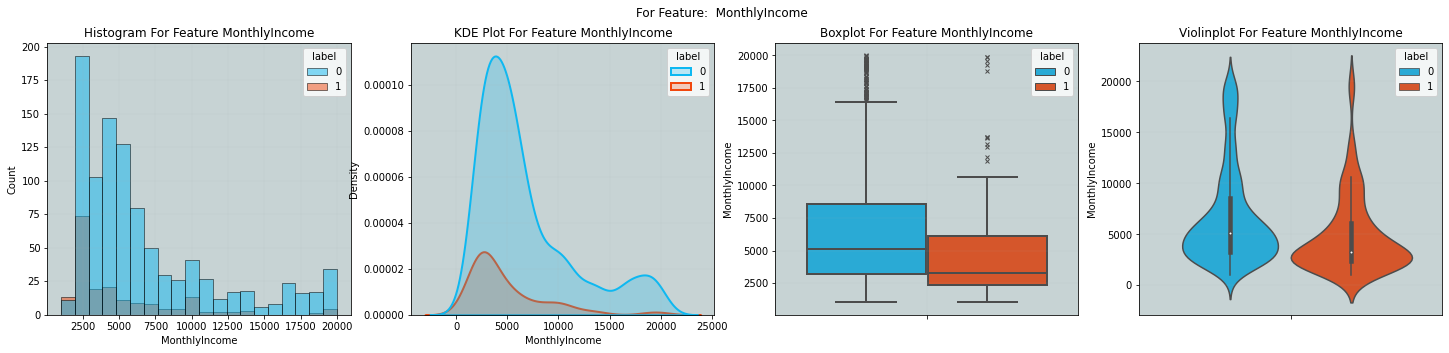

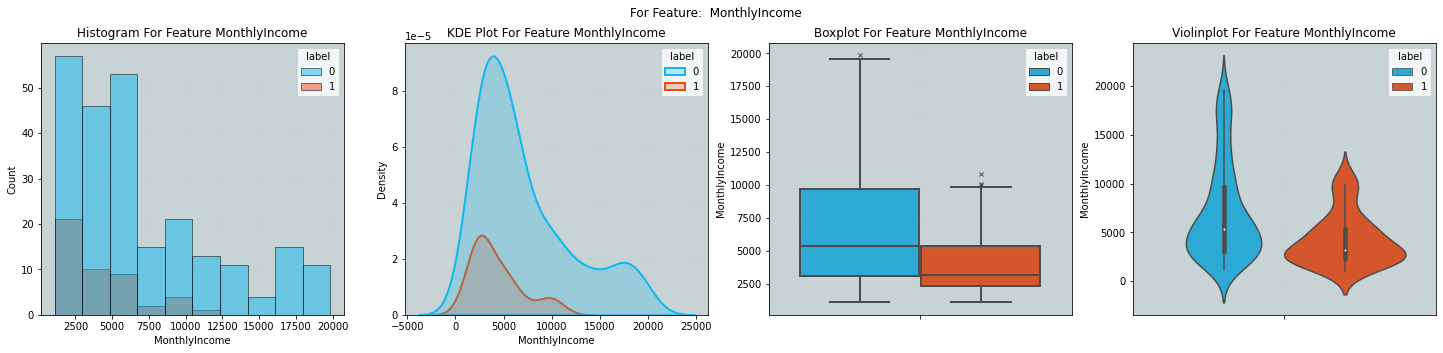

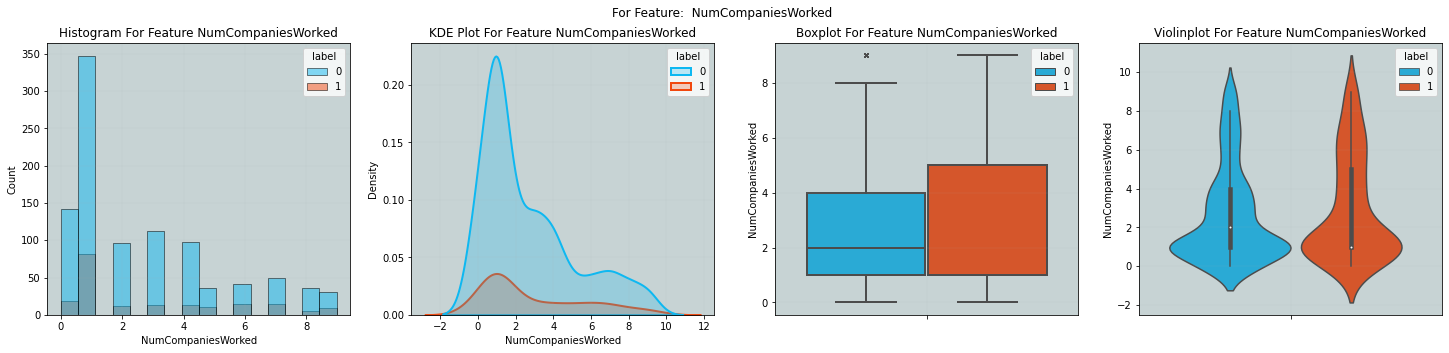

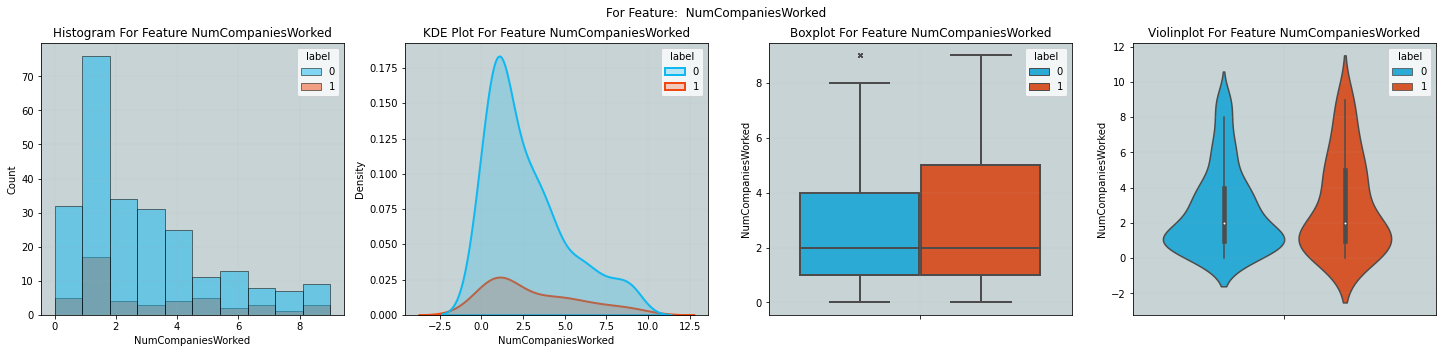

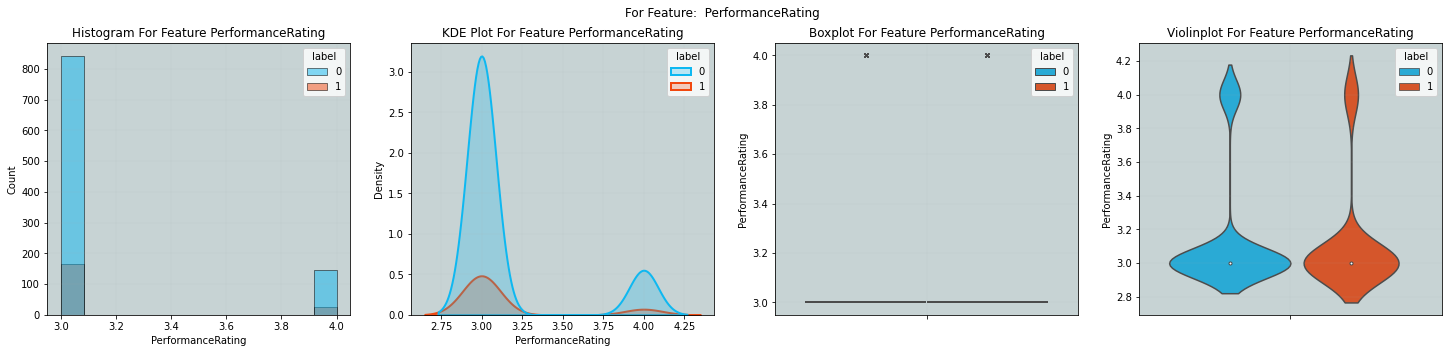

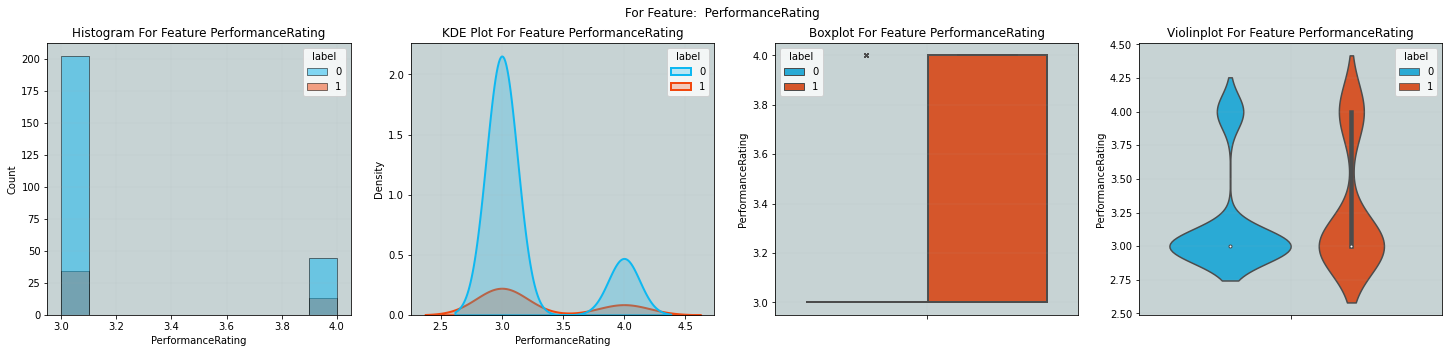

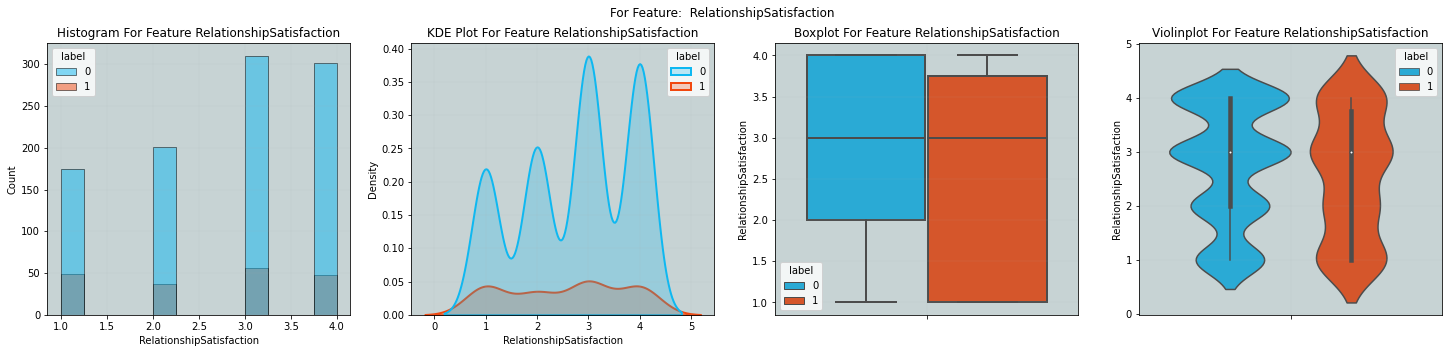

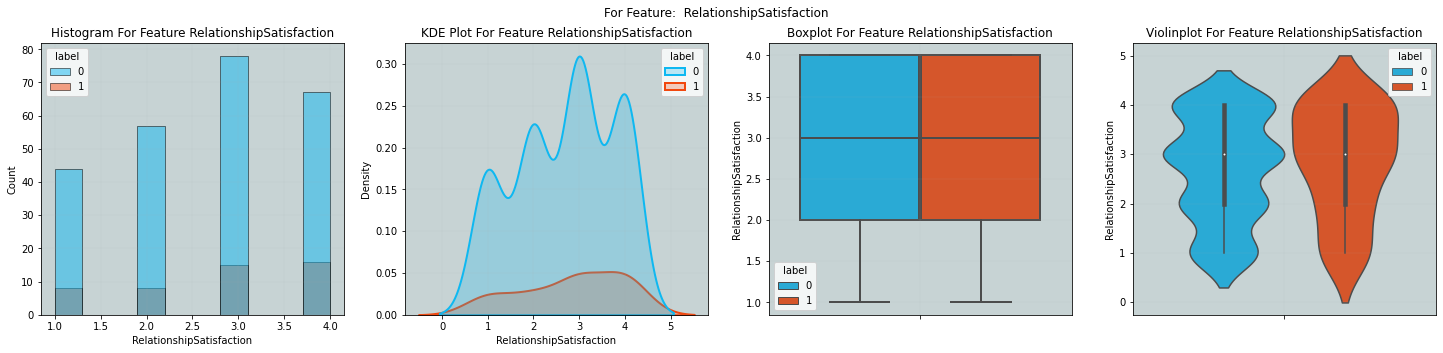

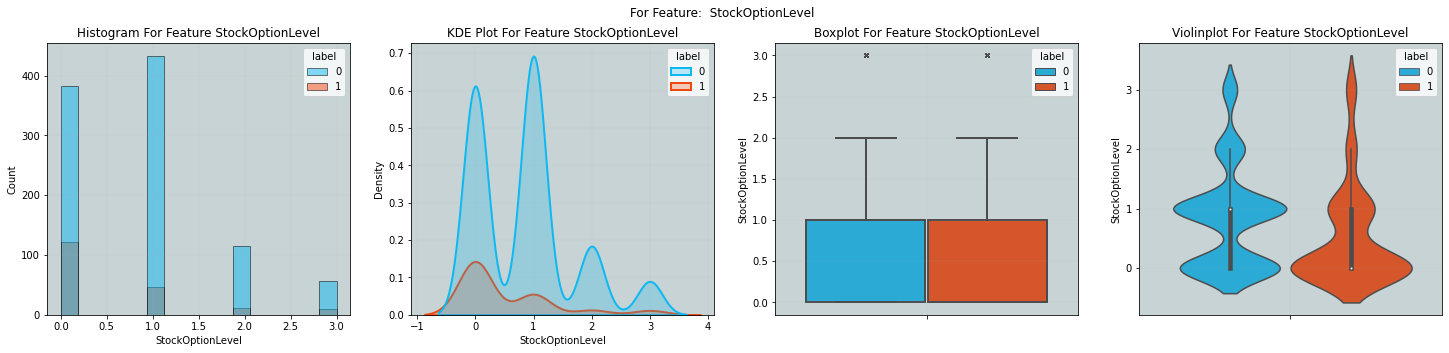

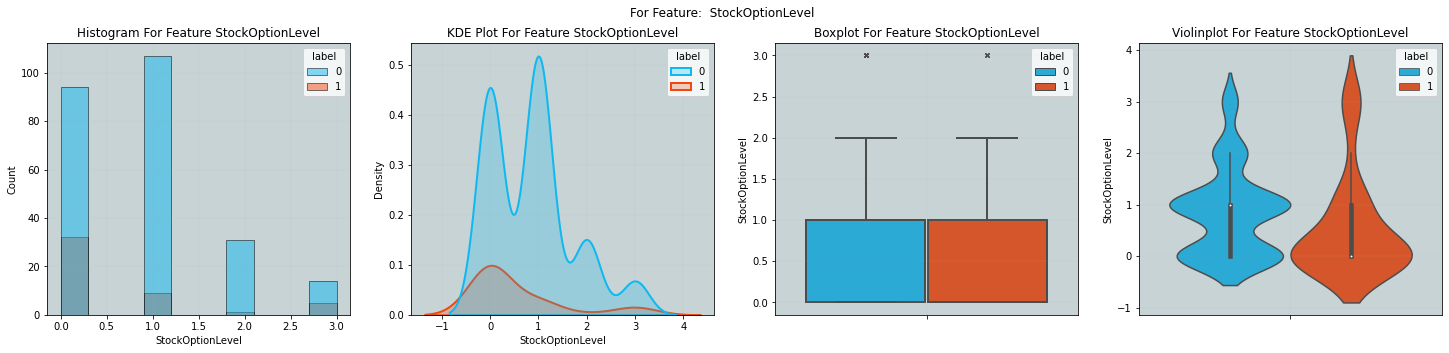

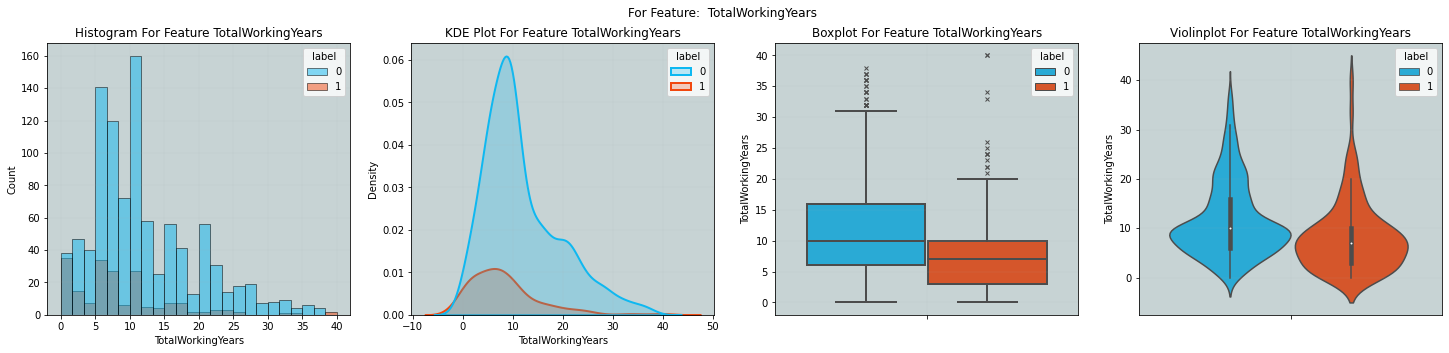

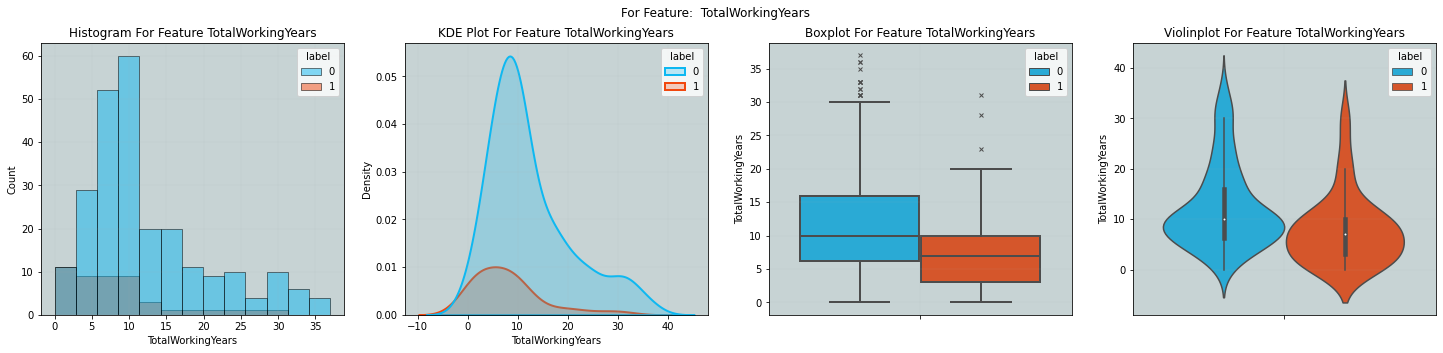

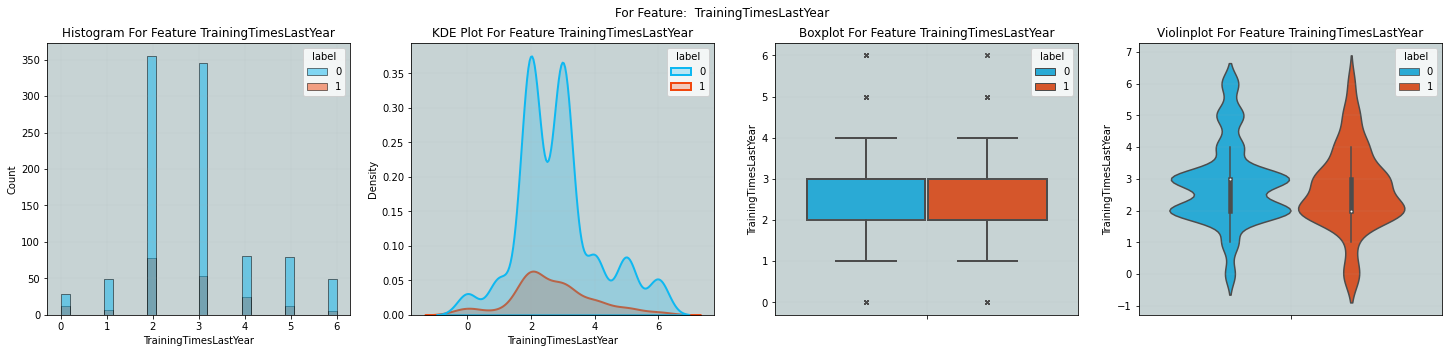

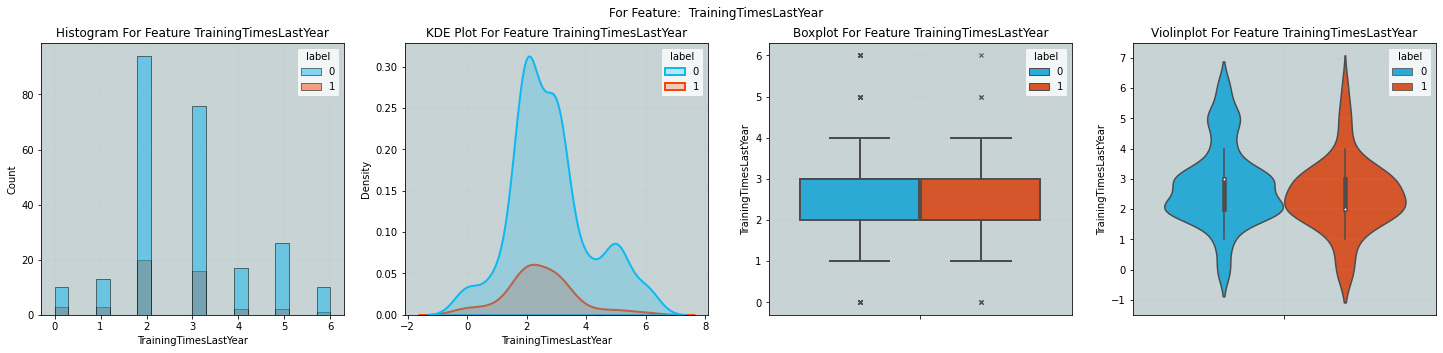

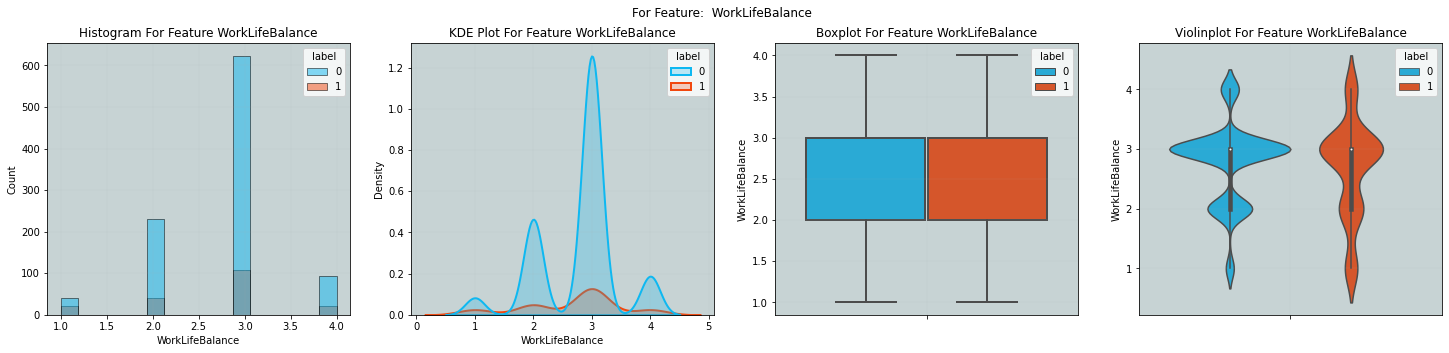

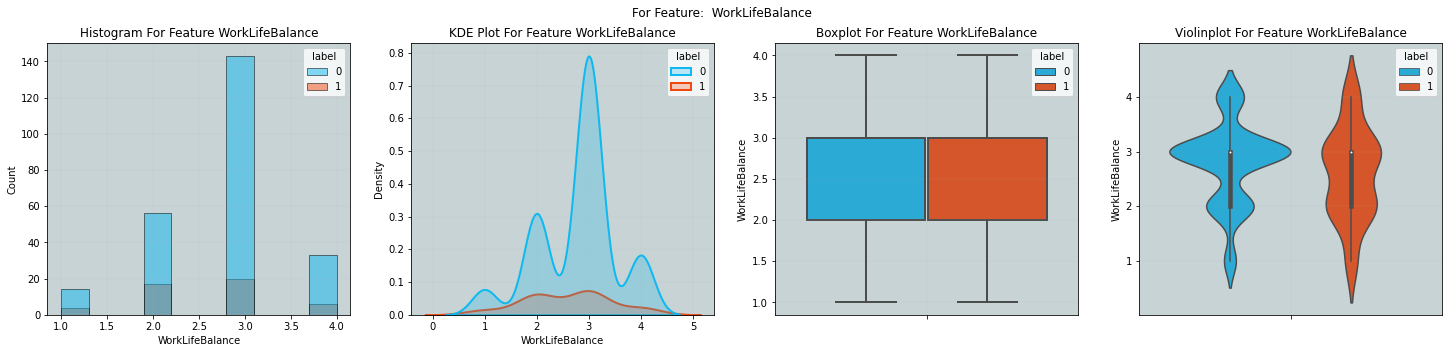

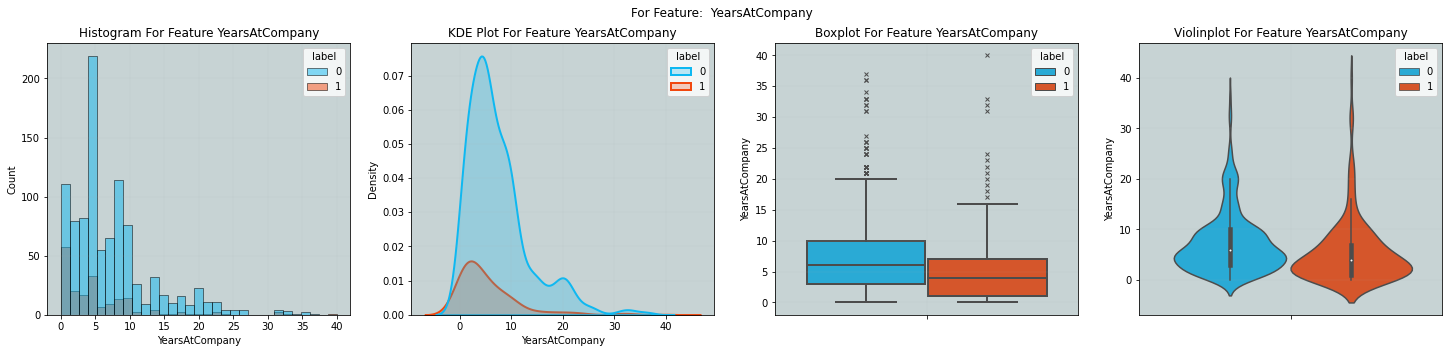

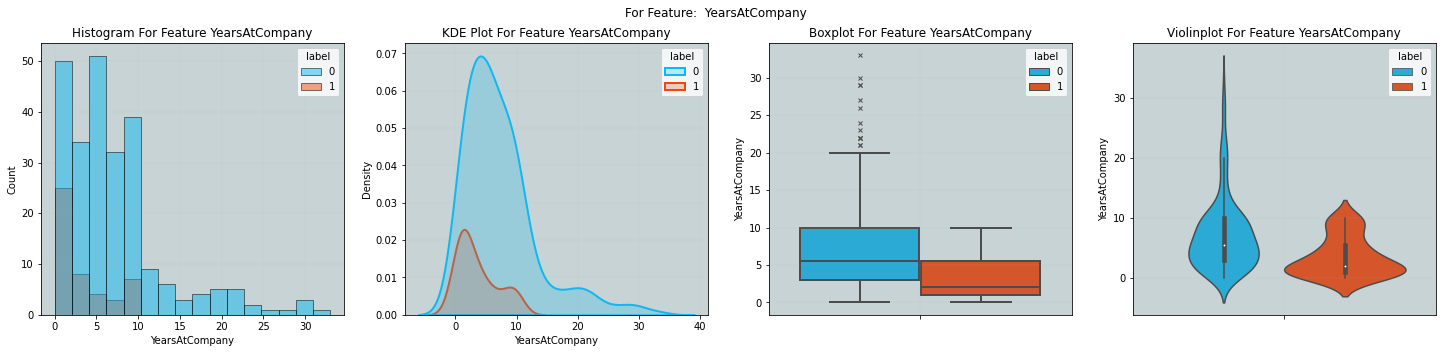

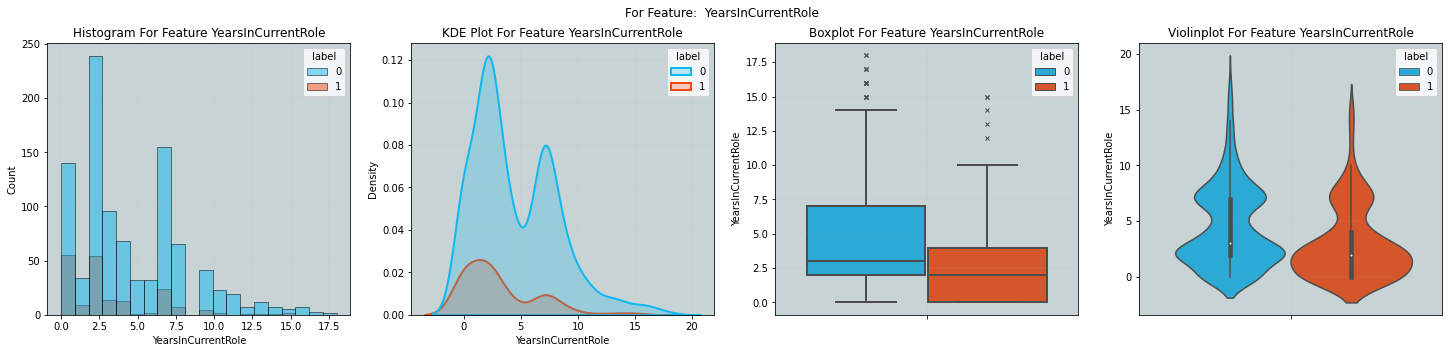

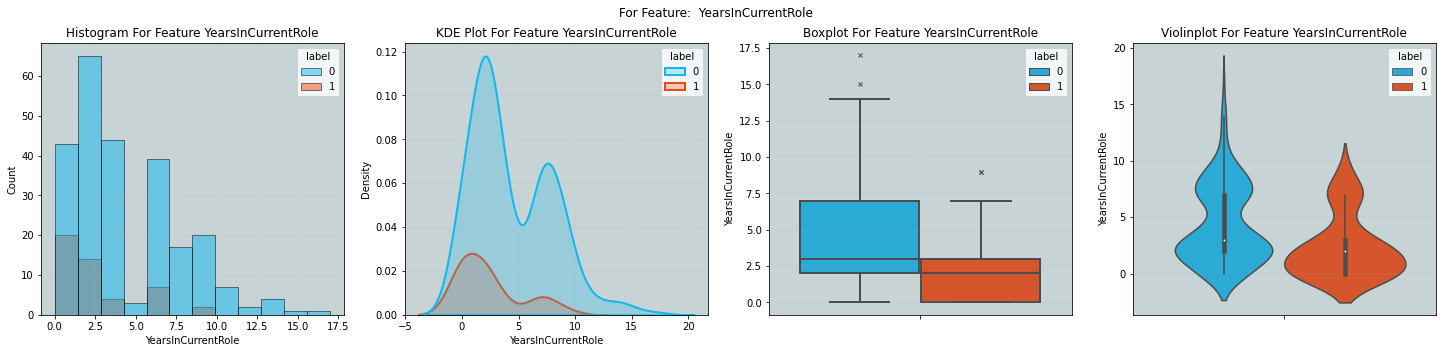

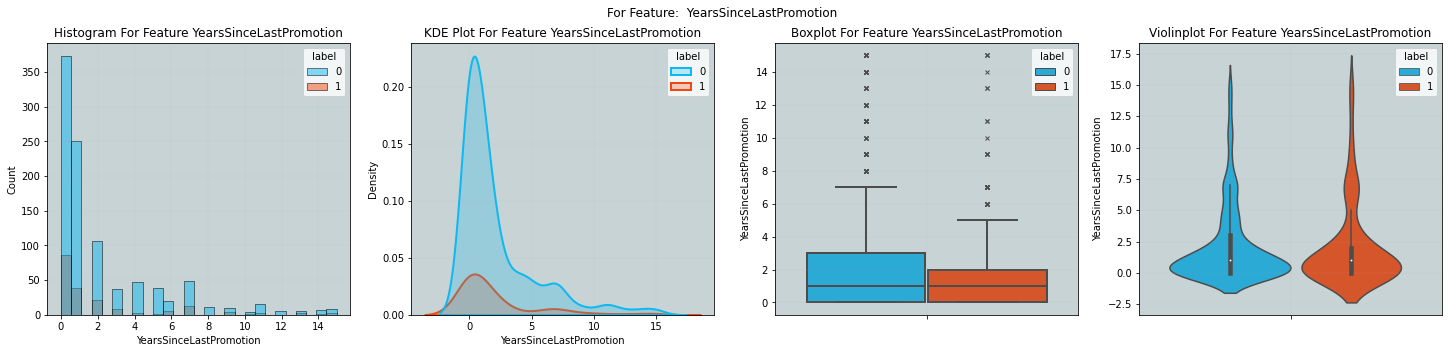

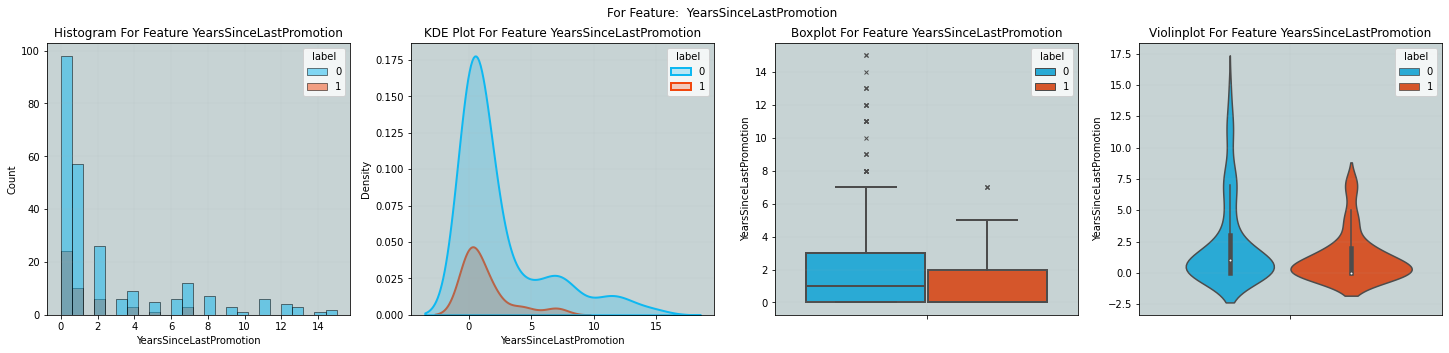

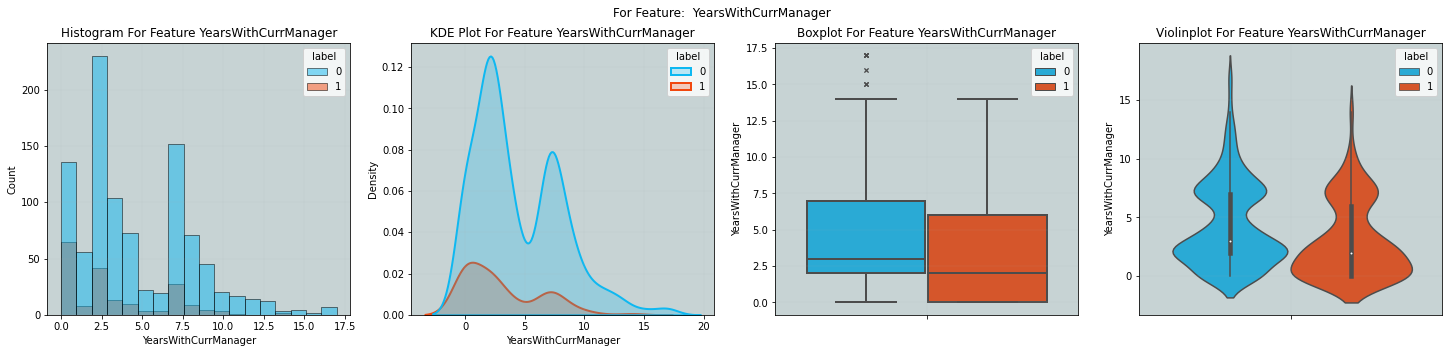

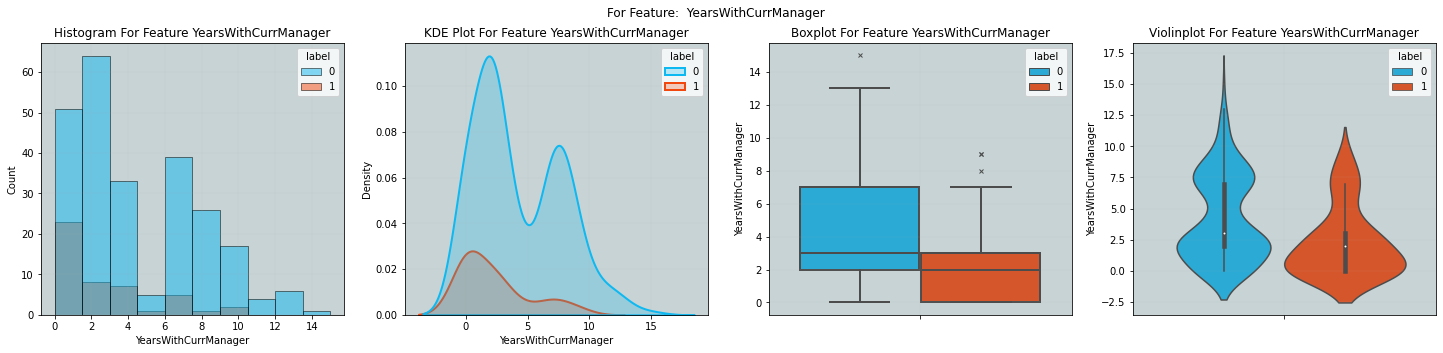

In [5]:
def feature_dist_clas(df, col, hue):
    
    fig, axes = plt.subplots(1, 4, figsize = (25, 5))
    order = sorted(df[hue].unique())
    palette = ["#0EB8F1", "#F1480F", "#971194", "#FEE715", "#101820"]
    
    sns.histplot(x = col, hue = hue, data = df, ax = axes[0], palette = palette[: df[hue].nunique()], edgecolor="black", linewidth=0.5)
    sns.kdeplot(x = col, hue = hue, data = df, fill = True, ax = axes[1], palette = palette[: df[hue].nunique()], linewidth = 2)
    sns.boxplot(y = col, hue = hue, data = df, x = [""] * len(df), ax = axes[2], 
                palette = palette[:len(order)], linewidth = 2, flierprops = dict(marker = "x", markersize = 3.5))
    
    sns.violinplot(y = col, hue = hue, data = df, x = [""] * len(df), ax = axes[3], palette = palette[: df[hue].nunique()])
    
    fig.suptitle("For Feature:  " + col)
    axes[0].set_title("Histogram For Feature " + col)
    axes[1].set_title("KDE Plot For Feature " + col)   
    axes[2].set_title("Boxplot For Feature " + col)   
    axes[3].set_title("Violinplot For Feature " + col)   
    
    for ax in axes:
        ax.set_facecolor("#C7D3D4FF")
        ax.grid(linewidth = 0.1)
for i in [x for x in df1.columns if (x not in df_cat.columns[:-1]) and x != "label"]:
    feature_dist_clas(df1, i, "label")
    feature_dist_clas(df2, i, "label")

In [6]:
df1.columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'label'],
      dtype='object')

In [10]:
dftrain,dftest = df1,df2
y = dftrain['label']
X = dftrain.drop(['label'],axis = 1)


In [11]:
categorical_features = df_cat.columns[:-1].tolist()
lgb_train = lgb.Dataset(X,label=y,
                        categorical_feature = categorical_features)
lgb_valid = lgb.Dataset(dftest.drop(['label'],axis = 1),label=dftest['label'],
                                categorical_feature = categorical_features,
                                reference=lgb_train)
boost_round = 50                   
early_stop_rounds = 10
params = {  
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': ['f1'],  
    'tree_learner': 'data',
    'num_leaves': 64,  
    'max_depth': -1,  
    'min_data_in_leaf': 64,  
    'learning_rate': 0.09,  
    'feature_fraction': 0.9,  
    'bagging_fraction': 0.9,  
    'bagging_freq': 10,  
    'lambda_l1': 0,    
    'lambda_l2': 0,  # 越小l2正则程度越高  
    'min_gain_to_split': 0.1,  
    'verbose': 1,  
    'max_bin': 64,
#             'scale_pos_weight':5,
    'min_sum_hessian_in_leaf': 1,
    'task': 'train',

}  
params['is_unbalance']=True


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True


results = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round= boost_round,
                valid_sets=(lgb_valid, lgb_train),
                valid_names=('validate','train'),
                early_stopping_rounds = early_stop_rounds,
                evals_result= results,feval=lgb_f1_score)






/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 190, number of negative: 987
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.989227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 1177, number of used features: 26


/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161427 -> initscore=-1.647646
[LightGBM] [Info] Start training from score -1.647646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's f1: 0	validate's f1: 0
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's f1: 0	validate's f1: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's f1: 0	validate's f1: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	train's f1: 0	validate's f1: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	train's f1: 0	validate's f1: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	train's f1: 0	validate's f1: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	train's f1: 0.151659	validate's f1: 0.25
[LightGBM] [Warning] No f

train accuracy: 0.87256 
valid accuracy: 0.843 



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

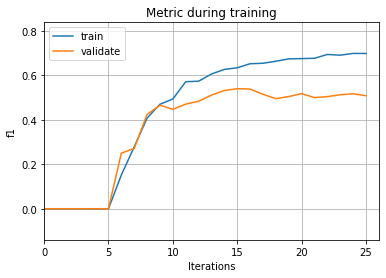

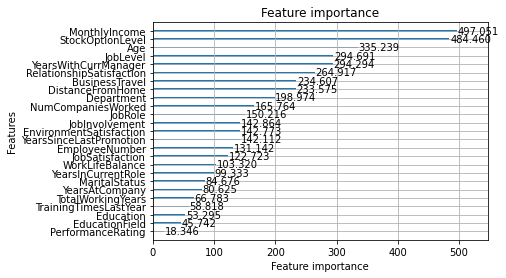

In [16]:
y_pred_train = gbm.predict(dftrain.drop('label',axis = 1), num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(dftest.drop('label',axis = 1), num_iteration=gbm.best_iteration)

print('train accuracy: {:.5} '.format(accuracy_score(dftrain['label'],y_pred_train>0.5)))
print('valid accuracy: {:.5} \n'.format(accuracy_score(dftest['label'],y_pred_test>0.5)))

lgb.plot_metric(results)
lgb.plot_importance(gbm,importance_type = "gain")

Confusion matrix, without normalization
[[220  26]
 [ 20  27]]


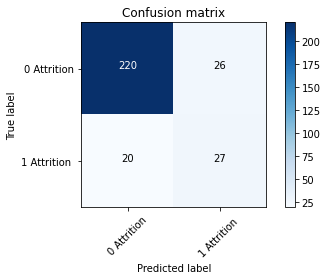

In [19]:
plot_confusion_matrix(confusion_matrix(dftest['label'],y_pred_test>0.5),target_names)

In [20]:
print(classification_report(dftest['label'],y_pred_test>0.5))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       246
           1       0.51      0.57      0.54        47

    accuracy                           0.84       293
   macro avg       0.71      0.73      0.72       293
weighted avg       0.85      0.84      0.85       293



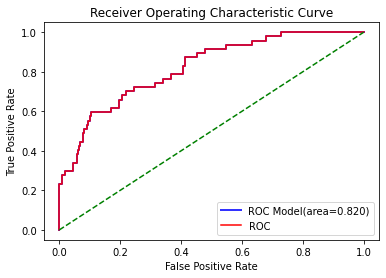

In [31]:
fper, tper, thresholds = roc_curve(dftest['label'], y_pred_test)
roc_auc=auc(fper,tper)
plot_roc_curve(fper, tper,roc_auc)